In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import models
import argparse
from argparse import Namespace
from dataloader import get_dataloaders
import time
import torch.nn as nn
import os
import math


data_path='save/scores.tsv'
flops_path='save/flops.pth'

In [2]:
df = pd.read_csv(data_path, sep='\t')
df.tail(10)

,epoch,lr,train_loss,val_loss,train_prec1,val_prec1,train_prec5,val_prec5
290,290,0.001,1.4470,9.9636,98.902,72.79,99.992,92.31
291,291,0.001,1.4289,10.1432,98.896,72.82,99.992,92.34
292,292,0.001,1.4264,10.0177,98.852,72.96,100.000,92.30
293,293,0.001,1.4378,10.0248,98.922,72.75,99.992,92.12
294,294,0.001,1.4402,10.0106,98.970,72.92,99.996,92.30
295,295,0.001,1.4450,10.0940,98.990,73.08,99.988,92.13
296,296,0.001,1.4372,10.0416,98.946,73.12,99.996,92.19
297,297,0.001,1.4162,10.0460,98.974,73.02,99.996,92.28
298,298,0.001,1.4206,10.1073,98.992,72.56,99.996,92.29
299,299,0.001,1.4289,10.0976,98.924,73.03,99.992,92.17


[]

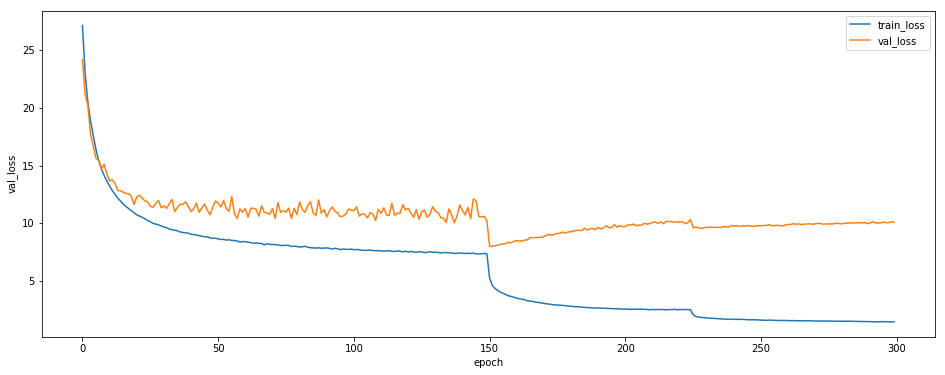

In [3]:
plt.figure(figsize=(16,6))
sns.lineplot(df.epoch,df.train_loss, label="train_loss")
sns.lineplot(df.epoch,df.val_loss, label="val_loss")
plt.plot()

[]

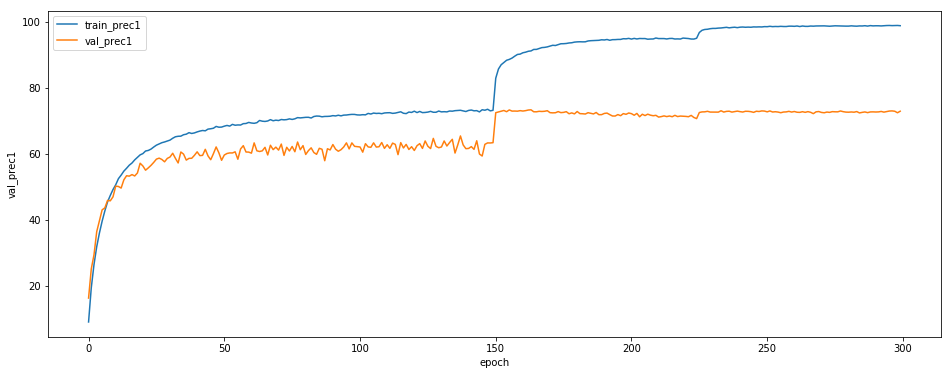

In [4]:
plt.figure(figsize=(16,6))
sns.lineplot(df.epoch,df.train_prec1, label="train_prec1")
sns.lineplot(df.epoch,df.val_prec1, label="val_prec1")
plt.plot()

In [5]:
flops = torch.load(flops_path)
print(flops)

[15140452.0, 25505992.0, 37095980.0, 46331024.0, 57335540.0, 66960728.0, 75937724.0]


In [6]:
args = Namespace(arch='msdnet', base=4, batch_size=64, bnFactor=[1, 2, 4], bottleneck=True, data='cifar100', data_root='/home/simon/GreenAI/MSDNet-PyTorch/', decay_rate=0.1, epochs=300, evalmode=None, evaluate_from=None, gpu=None, grFactor=[1, 2, 4], growthRate=6, lr=0.1, lr_type='multistep', momentum=0.9, nBlocks=7, nChannels=16, nScales=3, num_classes=100, optimizer='sgd', print_freq=10, prune='max', reduction=0.5, resume=False, save='/home/simon/GreenAI/MSDNet-PyTorch/save/', seed=0, splits=['train', 'val','test'], start_epoch=0, step=2, stepmode='even', use_valid=True, weight_decay=0.0001, workers=16)

model = getattr(models, args.arch)(args)
model = torch.nn.DataParallel(model).cuda()

train_loader, val_loader, test_loader = get_dataloaders(args)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [7]:
checkpoints = torch.load('save/save_models/checkpoint_299.pth.tar')

In [8]:
model.load_state_dict(checkpoints['state_dict'])

In [9]:
criterion = torch.nn.CrossEntropyLoss().cuda()

In [10]:
test_loader.dataset

Dataset CIFAR100
    Number of datapoints: 10000
    Split: test
    Root Location: /home/simon/GreenAI/MSDNet-PyTorch/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
                         )
    Target Transforms (if any): None

In [11]:
def validate(val_loader, model, criterion, T, flops):
    batch_time = AverageMeter()
    losses = AverageMeter()
    data_time = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    times=[]
    total_flops=np.zeros(len(flops))

    model.eval()
    
    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            batch_flops=[]
            target = target
            input = input.cuda()
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)
            
            data_time.update(time.time() - end)
            
            output, batch_flops = model(input_var, T, flops)
            total_flops+=batch_flops
            loss = 0.0
            
            loss += criterion(output, target_var)

            losses.update(loss.item(), input.size(0))

            prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
            top1.update(prec1.item(), input.size(0))
            top5.update(prec5.item(), input.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

#             if i % 10 == 0:
#                 print('Epoch: [{0}/{1}]\t'
#                       'Time {batch_time.avg:.3f}\t'
#                       'Data {data_time.avg:.3f}\t'
#                       'Loss {loss.val:.4f}\t'
#                       'Acc@1 {top1.val:.4f}\t'
#                       'Acc@5 {top5.val:.4f}'.format(
#                         i + 1, len(val_loader),
#                         batch_time=batch_time, data_time=data_time,
#                         loss=losses, top1=top1, top5=top5))
            times.append(data_time.sum+batch_time.sum)
    print('prec@1 {top1.avg:.3f} prec@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    # print(' * prec@1 {top1.avg:.3f} prec@5 {top5.avg:.3f}'.format(top1=top1[-1], top5=top5[-1]))
    
    return top1, top5, times, total_flops

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precor@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    #print(pred,target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


## Différence en temps et nombre de flops pour inférence sur dataset de test

In [27]:
T = torch.tensor([ 1.100e+00,  1.1000e+00,  1.1000e+00,  1.1e+00,  1.1e+00, 1.1e+00, -1.0000e+08])
top1, top5, times, flops_count = validate(test_loader, model, criterion, T, flops)
print(times[-1])
print(flops_count)

prec@1 72.580 prec@5 92.180
7.223769664764404
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 7.5937724e+11]


In [28]:
TEE = torch.tensor([ 0.800e+00,  0.8000e+00,  0.8000e+00,  8.0e-01,  8.0e-01, 0.8e-00, -1.0000e+08])
top1EE,top5EE,timesEE, flops_countEE =validate(test_loader,model, criterion, TEE, flops)
print(timesEE[-1])
print(flops_countEE)

prec@1 70.770 prec@5 90.660
5.967681884765625
[8.87230487e+10 4.46864980e+10 3.74298438e+10 2.37678153e+10
 1.83473728e+10 1.30573420e+10 2.66541411e+10]


In [29]:
diff_time = times[-1]-timesEE[-1]
diff_flops = flops_count-flops_countEE

In [30]:
print("diff temp d'inférence total {:.3f}".format(diff_time))

diff temp d'inférence total 1.256


In [31]:
for i in range(len(flops_countEE)):
    if i>0:
        flops_countEE[i]+=flops_countEE[i-1]
for i in range(len(flops_count)):
    if i>0:
        flops_count[i]+=flops_count[i-1]

[]

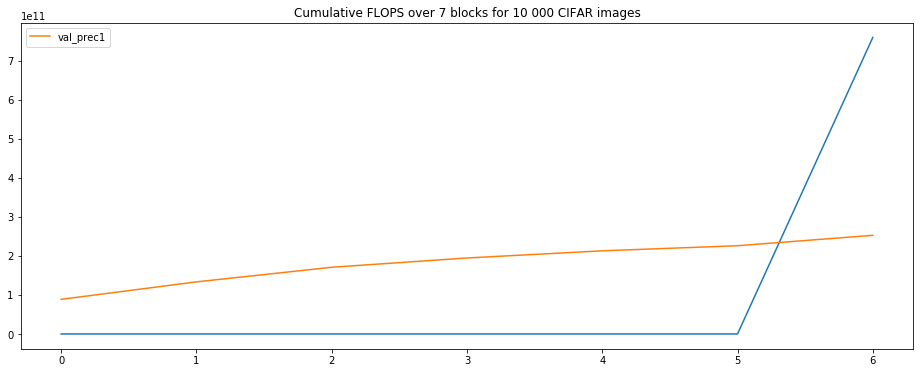

In [35]:
plt.figure(figsize=(16,6))
plt.title('Cumulative FLOPS over 7 blocks for 10 000 CIFAR images')
sns.lineplot(range(7),flops_count, label="")
sns.lineplot(range(7),flops_countEE, label="val_prec1")
plt.plot()